### SlideCNA

#### HTAPP-895-SMP-7359

In [4]:
libraries <- c("ggplot2", "Seurat", "glue", "dplyr", "anndata", "spacexr", 
               "data.table", "Matrix", "mltools", "enrichR", "R.utils")
lapply(libraries, function(x) suppressMessages(require(x, character.only = TRUE,quietly=TRUE,warn.conflicts = FALSE)))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [7]:
sample <- "HTAPP-895-SMP-7359"

In [8]:
# Assumes you're working in the repository root directory
source("code/RCTD.R")
source("code/utils.R")

#### RCTD

In [11]:
sn_adata <- read_h5ad(paste0("path/to/data/", sample, "_scRNAseq_processed.h5ad"))
so_adata <- read_h5ad(paste0("path/to/data/", sample, "_slide_seq_processed.h5ad"))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.9 GiB"


[1] 18107  6210


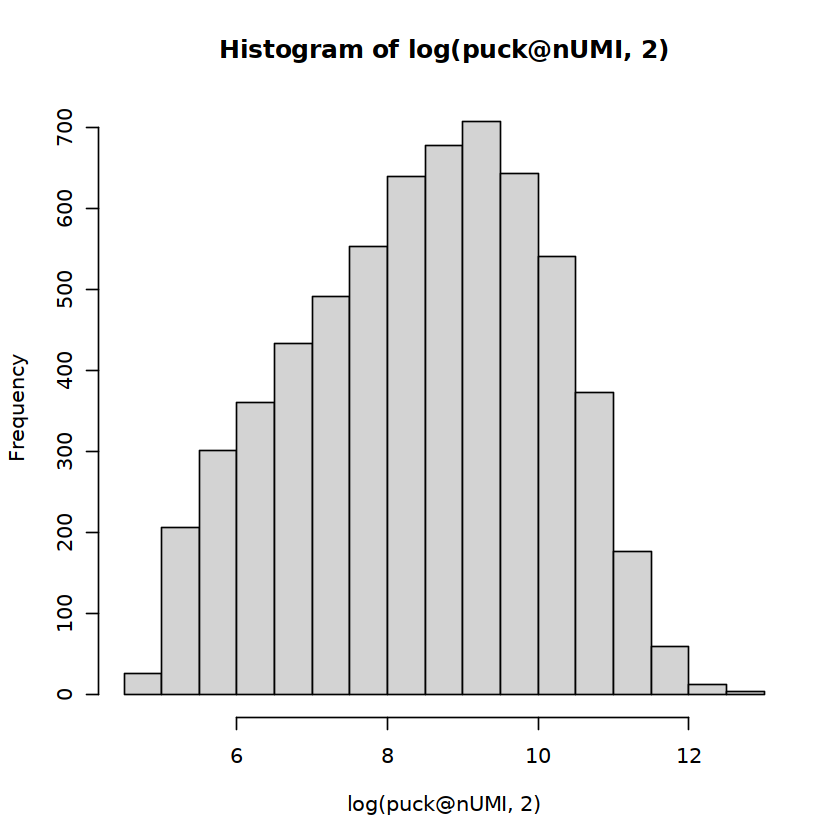

In [8]:
reference <- makeRef(sn_adata, RCTD_dir)
puck <- makePuck(so_adata, RCTD_dir)

In [9]:
# directory to output RCTD results to
saveRDS(reference, "path/to/results/RCTD/RCTD_SCRef.rds")
saveRDS(puck, "path/to/results/RCTD/RCTD_puck.rds")

In [10]:
# Get weights of cell type proportions contributing to a bead
myRCTD <- runRCTD(puck, reference, RCTD_dir, max_cores=4, doublet_mode='full')
saveRDS(myRCTD, "path/to/results/RCTD/myRCTD_full.rds")

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 9958

process_cell_type_info: number of genes in reference: 25424




                   MBC   Endothelial_vascular             Fibroblast 
                  6913                    230                    201 
Smooth muscle_vascular             Macrophage               B_plasma 
                    52                    851                    844 
                     B                      T                     NK 
                    11                    841                     15 


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.3 GiB"
End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: MBC found DE genes: 285

get_de_genes: Endothelial_vascular found DE genes: 361

get_de_genes: Fibroblast found DE genes: 335

get_de_genes: Smooth muscle_vascular found DE genes: 353

get_de_genes: Macrophage found DE genes: 374

get_de_genes: B_plasma found DE genes: 251

get_de_genes: B found DE genes: 594

get_de_genes: T found DE genes: 254

get_de_genes: NK found DE genes: 506

get_de_genes: total DE genes: 2608

create.RCTD: getting platform effect normalization differentially expressed genes: 

get_de_genes: MBC found DE genes: 607

get_de_genes: Endothelial_vascular found DE genes: 643

get_de_genes: Fibroblast found DE genes: 601

get_de_genes: Smooth muscle_vascular found DE genes: 652

get_de_genes: Macrophage found DE genes: 706

get_de_genes: B_plasma found DE genes: 53

In [11]:
barcodes <- colnames(myRCTD@spatialRNA@counts)
weights <- myRCTD@results$weights
norm_weights <- normalize_weights(weights)

In [12]:
head(norm_weights)

6 x 9 Matrix of class "dgeMatrix"
                       MBC Endothelial_vascular   Fibroblast
TCATATACTGTTGT-1 0.8495706         0.0135528624 4.072293e-02
TACTTTCAGGACTG-1 0.8493860         0.0192671290 2.430998e-02
AACCCAAGTTAGGG-1 0.9219918         0.0058287315 6.615746e-05
ACTCAGGCCTCCAC-1 0.9656727         0.0000464767 4.647670e-05
TTCGCTCCACACTT-1 0.6525868         0.0275476720 4.181886e-02
TATGCGGTCGACAA-1 0.7678902         0.0000638266 5.295606e-02
                 Smooth muscle_vascular   Macrophage     B_plasma           B
TCATATACTGTTGT-1           1.548742e-02 9.908094e-05 0.0203346981 0.038318881
TACTTTCAGGACTG-1           6.572118e-05 2.112636e-02 0.0401101594 0.007240087
AACCCAAGTTAGGG-1           6.615746e-05 2.040219e-02 0.0085668307 0.026447928
ACTCAGGCCTCCAC-1           4.647670e-05 1.738151e-02 0.0000464767 0.013684792
TTCGCTCCACACTT-1           1.197604e-02 1.090739e-01 0.0976668105 0.038851138
TATGCGGTCGACAA-1           3.756477e-03 2.552306e-02 0.0068324623 0.050

In [13]:
# Annotate bead with max likelihood cell type
RCTD_ct <- colnames(norm_weights)[apply(norm_weights,1,which.max)]
RCTD_df <- data.frame(RCTD=RCTD_ct, row.names=row.names(norm_weights))
head(RCTD_df)

,RCTD
,<chr>
TCATATACTGTTGT-1,MBC
TACTTTCAGGACTG-1,MBC
AACCCAAGTTAGGG-1,MBC
ACTCAGGCCTCCAC-1,MBC
TTCGCTCCACACTT-1,MBC
TATGCGGTCGACAA-1,MBC


In [14]:
# Add RCTD annotations to your metadata
beads_df <- merge(so_adata$obs, RCTD_df, by="row.names", all.x=FALSE) %>% 
                `rownames<-`(.[,'Row.names']) %>%
                rename(bc=Row.names, pos_x=x, pos_y=y) 

In [15]:
head(beads_df)

,bc,x_orig,y_orig,replicate,n_counts,n_genes,pos_x,pos_y,ut_HE1,Fibrosis_1,Tumor_1,ImmuneCells_1,Unidentifiable_1,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,RCTD
,<I<chr>>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
AAAAACCTGAGAGT-1,AAAAACCTGAGAGT-1,1427.94,1695.18,1,239,181,621.8775,1281.990,TRUE,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAAGCCACTTAT-1,AAAAAGCCACTTAT-1,1495.14,1830.06,1,278,231,518.1788,1172.651,TRUE,FALSE,TRUE,TRUE,FALSE,231,278,18,6.474820,0,MBC
AAAACACGAAGTCC-1,AAAACACGAAGTCC-1,446.82,1154.76,1,814,569,1718.1308,1511.945,TRUE,FALSE,TRUE,TRUE,FALSE,569,814,30,3.685504,0,MBC
AAAACCGACTATAA-1,AAAACCGACTATAA-1,1426.56,1544.64,1,162,140,667.2109,1425.549,TRUE,TRUE,FALSE,FALSE,FALSE,140,162,3,1.851852,1,MBC
AAAACCGCACGAGC-1,AAAACCGCACGAGC-1,635.76,1141.26,1,1062,721,1541.3936,1580.096,TRUE,FALSE,FALSE,FALSE,FALSE,720,1062,18,1.694915,0,MBC
AAAACGATGAATAT-1,AAAACGATGAATAT-1,475.80,1207.26,1,313,240,1675.0676,1470.212,TRUE,FALSE,TRUE,TRUE,FALSE,240,313,28,8.945687,2,MBC


In [16]:
counts <- get_adata_counts(so_adata)

In [17]:
counts <- counts %>% select(beads_df$bc)

In [18]:
# directory to output RCTD results to
saveRDS(beads_df, "path/to/results/RCTD/beads_df.rds")
saveRDS(counts, "path/to/results/RCTD/counts.rds")

In [19]:
# Reformat counts dataframe

In [20]:
counts_mat <- counts %>% as.data.table() %>% sparsify()
row.names(counts_mat) <- row.names(counts)

In [21]:
counts$GENE <- row.names(counts)
counts_long=reshape2::melt(counts,id.vars = "GENE")
counts_long = as.data.table(counts_long)
counts_long <- counts_long[counts_long$value!=0]

In [22]:
counts_long=merge(counts_long,beads_df,by.x="variable",by.y="bc",all.x=TRUE)
head(counts_long)

variable,GENE,value,x_orig,y_orig,replicate,n_counts,n_genes,pos_x,pos_y,⋯,Fibrosis_1,Tumor_1,ImmuneCells_1,Unidentifiable_1,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,RCTD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
AAAAACCTGAGAGT-1,ACADM,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAACCTGAGAGT-1,ACTG1,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAACCTGAGAGT-1,ADAP2,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAACCTGAGAGT-1,AFTPH,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAACCTGAGAGT-1,APBB2,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC
AAAAACCTGAGAGT-1,ARMC1,1,1427.94,1695.18,1,239,181,621.8775,1281.99,⋯,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC


In [23]:
summary(counts_long[,sum(value),by=c("pos_x","pos_y")]$V1)
summary(counts_long[,sum(value!=0),by=c("pos_x","pos_y")]$V1)
length(unique(counts_long$variable))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   244.0   491.5   711.1   943.0  7112.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   47.0   189.8   356.0   467.7   628.0  3107.0 

[1] 5220

In [24]:
# Plot distribution of marker gene counts over space

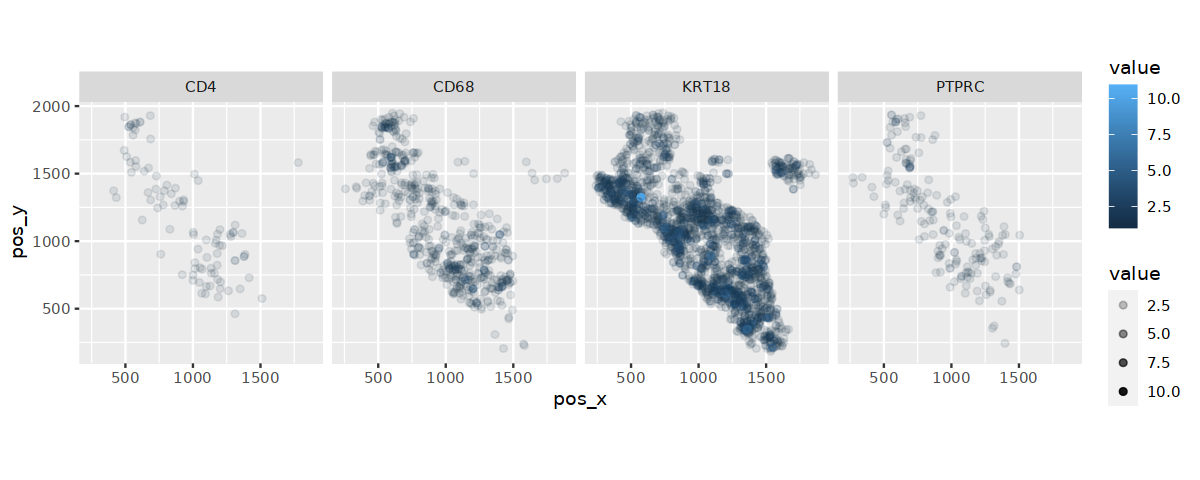

In [25]:
options(repr.plot.width = 10, repr.plot.height =4)
ggplot(counts_long[GENE%in%c("KRT18","CD4","CD68","PTPRC")],aes(x=pos_x,y=pos_y))+geom_point(aes(col=value,alpha=value))+coord_fixed()+facet_grid(~GENE)

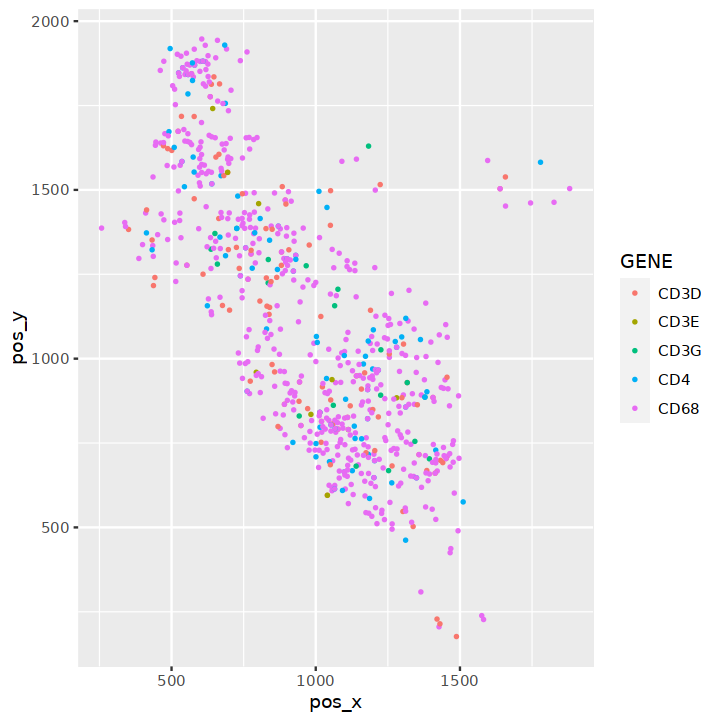

In [26]:
options(repr.plot.width = 6, repr.plot.height =6)
ggplot(counts_long[GENE%in%c("CD3E","CD3D","CD3G","CD3A","CD3B","CD4","CD68","CD56")],aes(x=pos_x,y=pos_y))+geom_point(aes(col=GENE),size=0.5)

#### Create a Seurat Object from Slide-seq data

In [27]:
so=make_seurat_annot(counts_mat, beads_df)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix

PC_ 1 
Positive:  TFF1, AGR2, NDRG1, DHRS2, DSP, MAL2, EPCAM, STC2, TOP2A, BHLHE40 
	   CRISPLD1, RP11-206M11.7, HILPDA, DDIT3, MAGEA1, MLPH, CDK1, CCDC34, IER3, H19 
	   PITX1, PEG10, GALNT7, ZMYND8, GOLM1, AP1M2, FBXO32, MUCL1, CENPF, CENPA 
Negative:  IGHG4, IGHG3, IGKC, IGHG1, IGLC2, IGHG2, CD74, AC096579.7, HLA-DRA, IGLC7 
	   IGHM, IGLC3, APOE, HLA-DRB1, IGLL5, MZB1, CTSB, SPARC, HLA-DPB1, COL3A1 
	   IGJ, IGFBP7, C1QB, IGHA1, COL1A2, LYZ, TAGLN, APOC1, IGLV3-1, CTSZ 
PC_ 2 
Positive:  IGLC7, IGJ, IGHG2, IGLC3, IGLV6-57, IGHA1, MZB1, IGLC2, AC096579.7, IGLL5 
	   IGHG3, IGLV1-40, IGHG1, IGHD, IGHG4, IGKC, IGLV3-1, IGLJ3, PIM2, SLAMF7 
	   IGLV3-10, IGLV1-51, EAF2, IGLJ2, IGLV2-14, IGHM, CDKN1A, IGHA2, GLRX, IGLV2-8 
Negative:  SPP1, CTSB, FN1, RNASE1, COL1A2, APOC1, COL1A1, COL3A1, APOE, GPNMB 
	   CTSZ, HLA-DRA, H

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5220
Number of edges: 159826

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6842
Number of communities: 8
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
21:53:40 UMAP embedding parameters a = 0.9922 b = 1.112

21:53:40 Read 5220 rows and found 10 numeric columns

21:53:40 Using Annoy for neighbor search, n_neighbors = 30

21:53:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:53:41 Writing NN index file to temp file /local/scratch/39682465.1.interactive/RtmpDunFTQ/file263364c8ae882

21:53:41 Searching Annoy index using 1 thread, search_k = 3000

21:53:43 Annoy recall = 100%

21:53:44 Commencing smooth kNN distance calibration using 1

In [28]:
# Annotate which RCTD cell types are normal/reference vs malignant
so@meta.data$cluster_type <- 'Normal'
so@meta.data[so@meta.data$RCTD == 'MBC',]$cluster_type <- 'Malignant' # MBC = metastatic breast cancer
md=as.data.table(so@meta.data)
rownames(md) <- md$bc

In [31]:
dim(md)

[1] 5220   26

In [29]:
# directory to output results to
save(so, file="path/to/results/so.Robj")
save(md, file="path/to/results/md.Robj")

In [32]:
# TSNE Plots

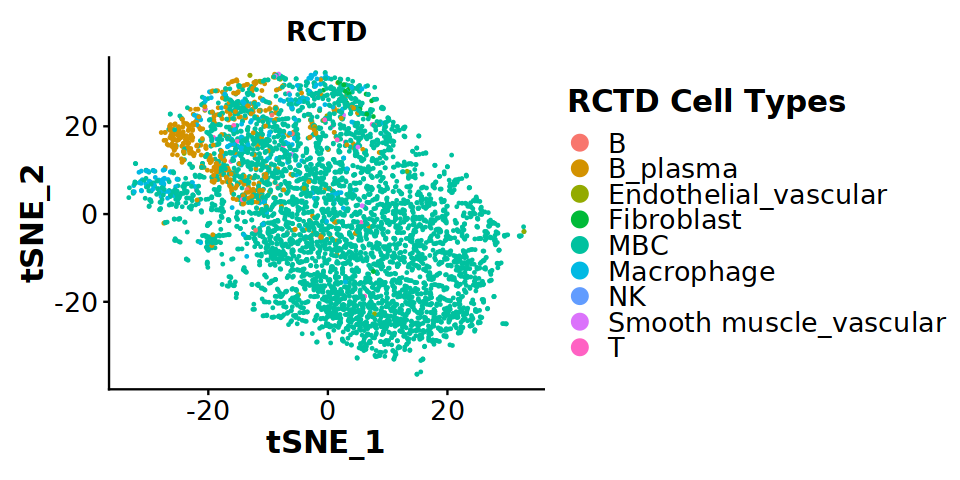

In [33]:
legend_title = "RCTD Cell Types"
options(repr.plot.width = 8, repr.plot.height = 4)
TSNEPlot(so, label.size = 18, group.by="RCTD") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

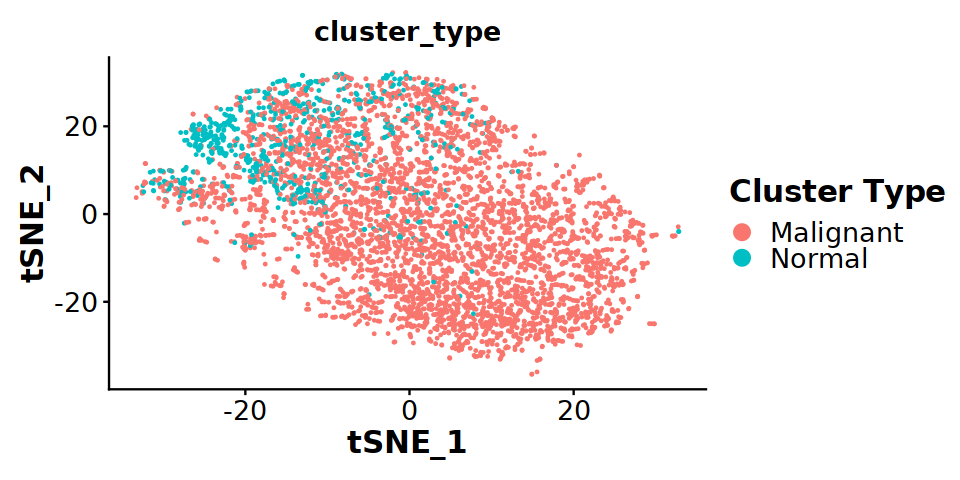

In [34]:
legend_title = "Cluster Type"
options(repr.plot.width = 8, repr.plot.height =4)
TSNEPlot(so, label.size = 18, group.by="cluster_type") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

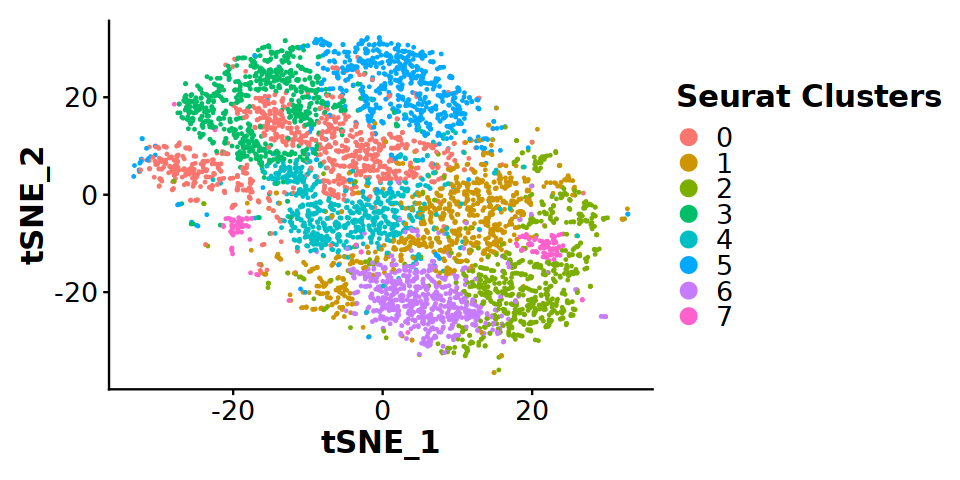

In [35]:
legend_title = "Seurat Clusters"
options(repr.plot.width = 8, repr.plot.height =4)
TSNEPlot(so, label.size = 18) +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

In [36]:
# Spatial plots

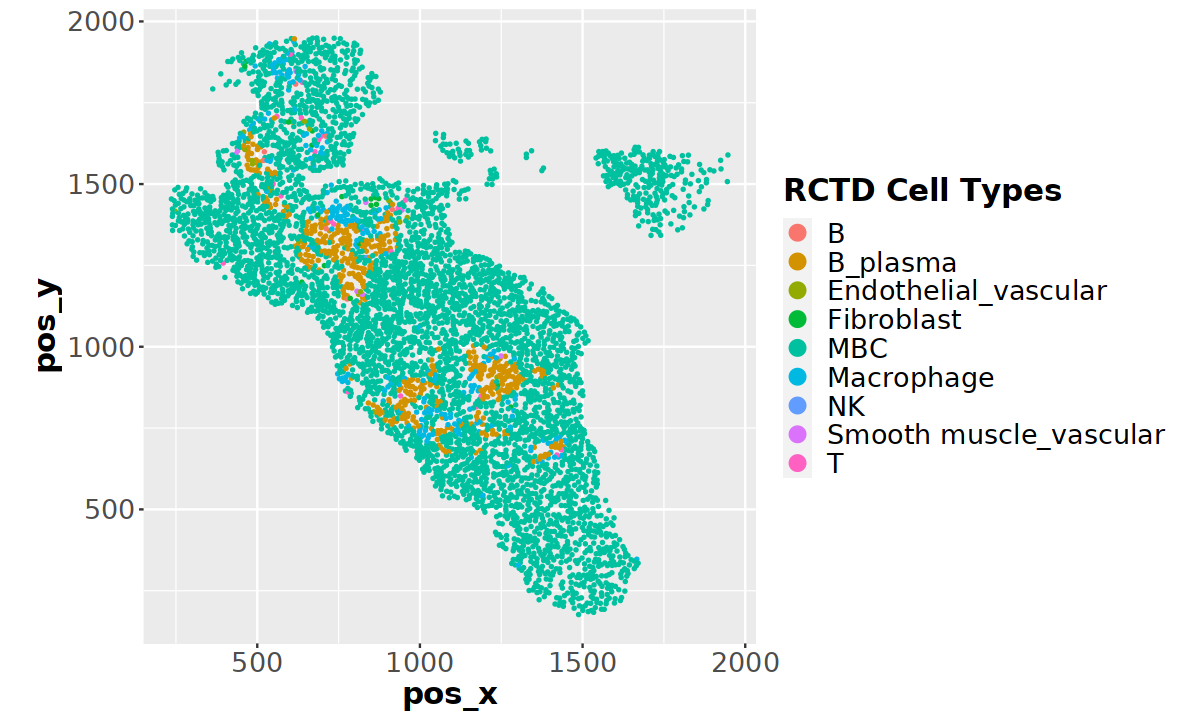

In [37]:
legend_title = "RCTD Cell Types"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=(RCTD)))+geom_point(size=0.5, position="jitter")+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

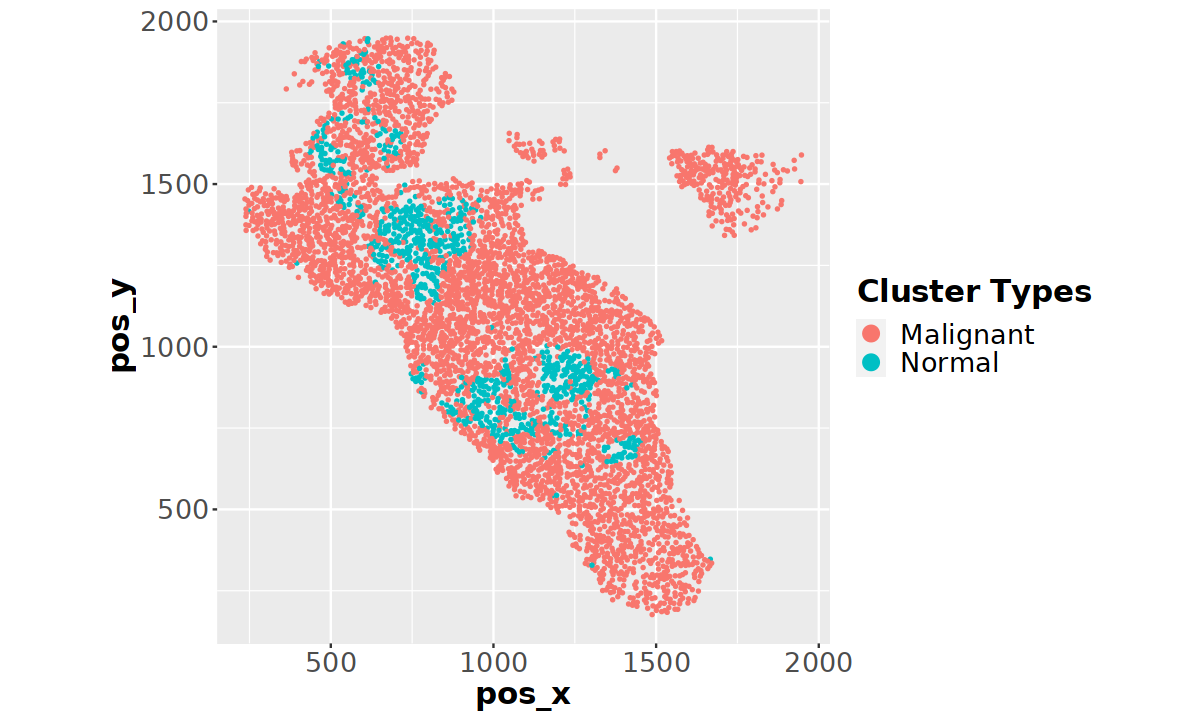

In [38]:
legend_title = "Cluster Types"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=(cluster_type)))+geom_point(size=0.5, position="jitter")+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

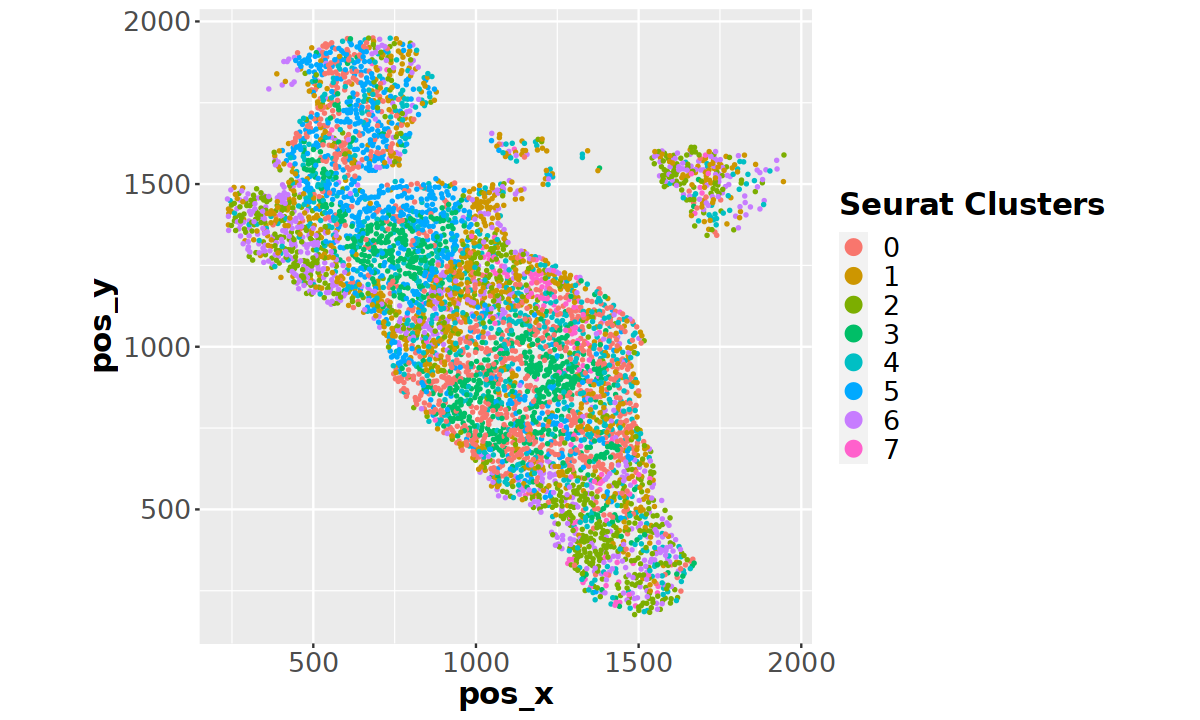

In [39]:
legend_title = "Seurat Clusters"
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(md,aes(x=pos_x,y=pos_y,col=as.factor(seurat_clusters)))+geom_point(size=0.5)+coord_fixed() +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=title_size, face='bold'),
          legend.title=element_text(size=title_size, face='bold'), legend.text=element_text(size=text_size)) +
    labs(color = legend_title) +
    guides(color = guide_legend(override.aes = list(size = legend_size_pt)))

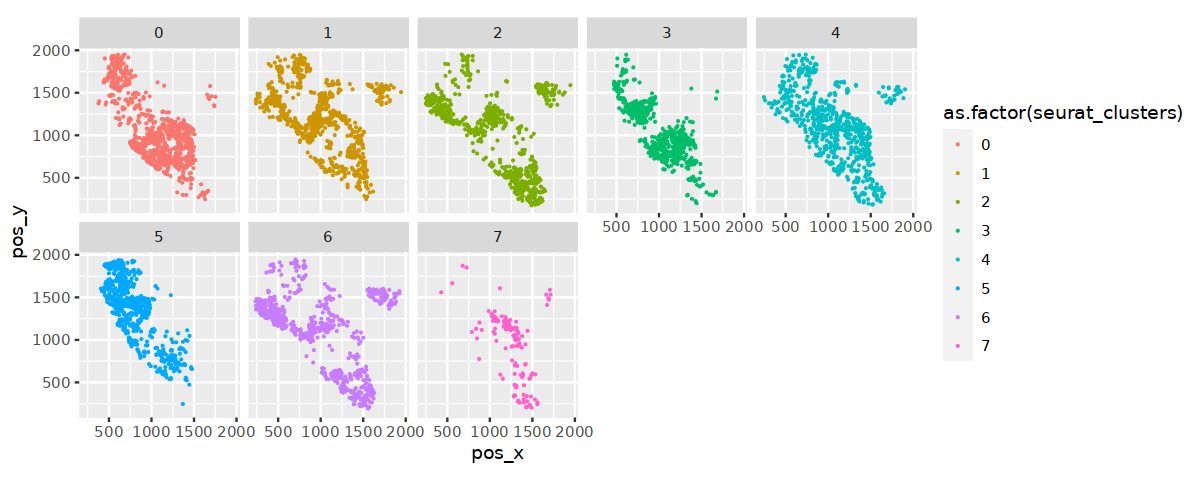

In [40]:
options(repr.plot.width = 10, repr.plot.height =4)
ggplot(md,aes(x=pos_x,y=pos_y,col=as.factor(seurat_clusters)))+geom_point(size=0.1)+coord_fixed()+facet_wrap(~seurat_clusters,ncol=5)

#### RCTD cell type markers

In [41]:
so=SetIdent(so,value = so@meta.data$RCTD)
markers_RCTD=FindAllMarkers(so)

Calculating cluster MBC

Calculating cluster Macrophage

Calculating cluster B_plasma

Calculating cluster Endothelial_vascular

Calculating cluster T

Calculating cluster Fibroblast

Calculating cluster NK

Calculating cluster B

Calculating cluster Smooth muscle_vascular

Warning message:
"The following tests were not performed: "
Warning message:
"When testing NK versus all:
	Cell group 1 has fewer than 3 cells"


In [42]:
markers_RCTD=as.data.table(markers_RCTD)

In [43]:
markers_RCTD[order(avg_log2FC,decreasing=TRUE),.SD[1:5,],by="cluster"]

cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Smooth muscle_vascular,2.032356e-29,4.409022,0.625,0.023,3.668402e-25,C1R
Smooth muscle_vascular,3.026998e-03,4.382662,0.125,0.012,1.000000e+00,KDM1B
Smooth muscle_vascular,2.535005e-08,4.342892,0.125,0.004,4.575683e-04,C19orf38
Smooth muscle_vascular,5.810278e-27,3.745777,0.250,0.004,1.048755e-22,DDR2
Smooth muscle_vascular,4.794349e-09,3.701821,0.375,0.030,8.653801e-05,BGN
B,2.046218e-04,3.943432,0.286,0.035,1.000000e+00,AP1B1
B,2.281637e-04,3.850548,0.286,0.036,1.000000e+00,SNAPIN
B,1.995470e-11,3.847497,0.286,0.012,3.601823e-07,GCFC2
B,3.377856e-09,3.757683,0.286,0.015,6.097030e-05,SLC4A7


In [ ]:
# Get gene ontology terms associated with each cluster

In [44]:
en_RCTD=markers_RCTD[order(avg_log2FC,decreasing=TRUE),run_enrichr(gene,50),by="cluster"]

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


In [45]:
en_RCTD[GO_Biological_Process_2018.Adjusted.P.value<0.05][order(GO_Biological_Process_2018.Adjusted.P.value),.SD[1:2],by="cluster"]

cluster,GO_Biological_Process_2018.Term,GO_Biological_Process_2018.Overlap,GO_Biological_Process_2018.P.value,GO_Biological_Process_2018.Adjusted.P.value,GO_Biological_Process_2018.Old.P.value,GO_Biological_Process_2018.Old.Adjusted.P.value,GO_Biological_Process_2018.Odds.Ratio,GO_Biological_Process_2018.Combined.Score,GO_Biological_Process_2018.Genes
<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>


In [46]:
save(markers_RCTD, file="path/to/results/markers_RCTD.Robj")

#### Seurat cluster markers

In [48]:
so=SetIdent(so,value = so@meta.data$seurat_clusters)
markers=FindAllMarkers(so)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



In [49]:
markers=as.data.table(markers)

In [50]:
markers[avg_log2FC>0&p_val_adj<0.05][order(avg_log2FC,decreasing=TRUE),.SD[1:4,],by="cluster"]

cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7,1.544327e-147,4.2597556,0.743,0.089,2.787510e-143,HBB
7,0.000000e+00,3.9952276,0.571,0.011,0.000000e+00,HBA2
7,0.000000e+00,3.8208409,0.421,0.004,0.000000e+00,HBA1
7,1.114457e-18,1.4598580,0.243,0.059,2.011595e-14,RP11-624L4.1
3,4.163997e-120,2.6907017,0.323,0.055,7.516015e-116,IGHA1
3,7.246465e-51,2.4926366,0.162,0.031,1.307987e-46,IGHD
3,1.374925e-128,2.4581510,0.375,0.071,2.481740e-124,IGJ
3,1.446740e-161,2.4008080,0.474,0.096,2.611365e-157,IGLC7
5,4.233643e-160,2.3941086,0.463,0.089,7.641726e-156,COL1A2


In [51]:
save(markers, file="path/to/results/markers.Robj")

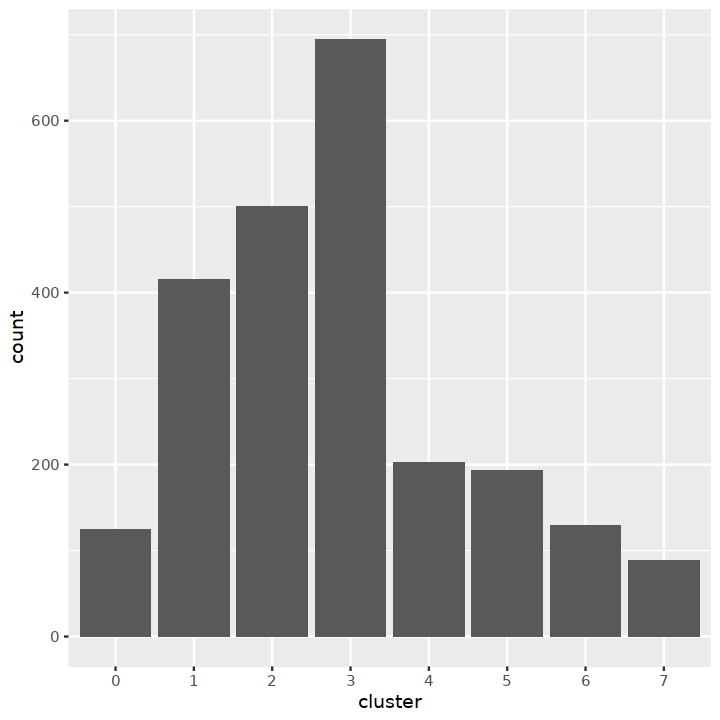

In [52]:
# Number of genes in each cluster
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data=markers, aes(x=cluster)) +
  geom_bar(stat="count")

In [ ]:
# Get gene ontology terms associated with each cluster

In [53]:
en=markers[avg_log2FC>0&p_val_adj<0.05][order(avg_log2FC,decreasing=TRUE),run_enrichr(gene,100),by="cluster"]

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


In [54]:
en[GO_Biological_Process_2018.Adjusted.P.value<0.05][order(GO_Biological_Process_2018.Adjusted.P.value),.SD[1:2],by="cluster"]

cluster,GO_Biological_Process_2018.Term,GO_Biological_Process_2018.Overlap,GO_Biological_Process_2018.P.value,GO_Biological_Process_2018.Adjusted.P.value,GO_Biological_Process_2018.Old.P.value,GO_Biological_Process_2018.Old.Adjusted.P.value,GO_Biological_Process_2018.Odds.Ratio,GO_Biological_Process_2018.Combined.Score,GO_Biological_Process_2018.Genes
<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
7,oxygen transport (GO:0015671),2/7,8.174868e-06,0.0008256616,0,0,726.6182,8511.929,HBB;HBA1
7,gas transport (GO:0015669),2/10,1.749845e-05,0.0008836719,0,0,454.0682,4973.590,HBB;HBA1
3,oxygen transport (GO:0015671),2/7,8.174868e-06,0.0008256616,0,0,726.6182,8511.929,HBB;HBA1
3,gas transport (GO:0015669),2/10,1.749845e-05,0.0008836719,0,0,454.0682,4973.590,HBB;HBA1
5,oxygen transport (GO:0015671),2/7,8.174868e-06,0.0008256616,0,0,726.6182,8511.929,HBB;HBA1
5,gas transport (GO:0015669),2/10,1.749845e-05,0.0008836719,0,0,454.0682,4973.590,HBB;HBA1
0,oxygen transport (GO:0015671),2/7,8.174868e-06,0.0008256616,0,0,726.6182,8511.929,HBB;HBA1
0,gas transport (GO:0015669),2/10,1.749845e-05,0.0008836719,0,0,454.0682,4973.590,HBB;HBA1
2,oxygen transport (GO:0015671),2/7,8.174868e-06,0.0008256616,0,0,726.6182,8511.929,HBB;HBA1


In [55]:
markers[avg_log2FC>0&p_val_adj<0.05][order(avg_log2FC,decreasing=TRUE),.SD[cluster==7]]

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.544327e-147,4.2597556,0.743,0.089,2.787510e-143,7,HBB
0.000000e+00,3.9952276,0.571,0.011,0.000000e+00,7,HBA2
0.000000e+00,3.8208409,0.421,0.004,0.000000e+00,7,HBA1
1.114457e-18,1.4598580,0.243,0.059,2.011595e-14,7,RP11-624L4.1
1.355658e-13,1.3618346,0.314,0.116,2.446963e-09,7,MTRNR2L12
2.675445e-09,1.2066810,0.200,0.070,4.829178e-05,7,ATHL1
7.413823e-08,1.1456218,0.300,0.145,1.338195e-03,7,CRISPLD1
6.561517e-08,0.9290299,0.143,0.045,1.184354e-03,7,EPS8L1
3.035905e-15,0.7617119,0.979,0.878,5.479809e-11,7,MT-RNR2


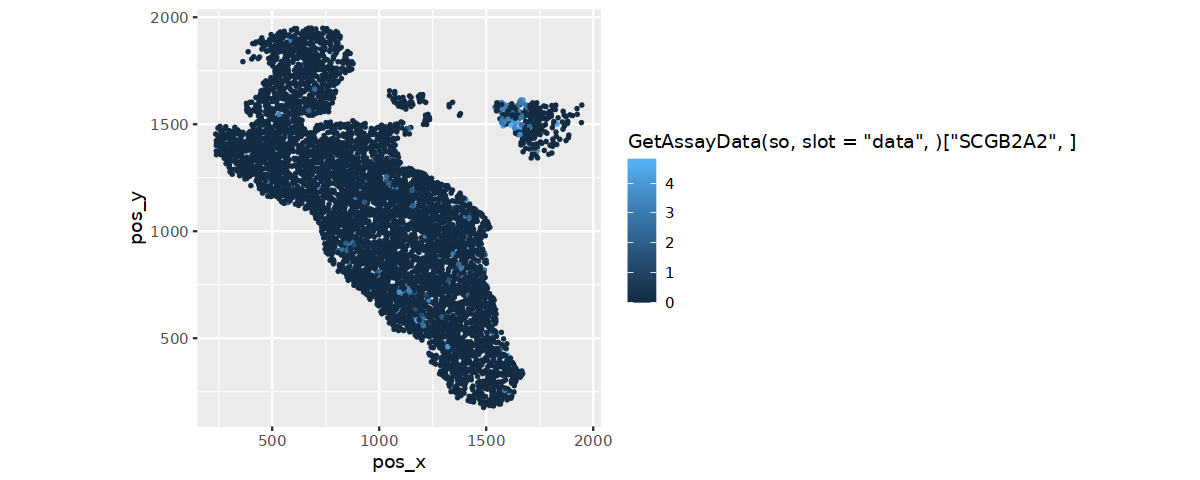

In [57]:
options(repr.plot.width = 10, repr.plot.height =4)
ggplot(md,aes(x=pos_x,y=pos_y,col=GetAssayData(so, slot = "data",)["SCGB2A2",]))+geom_point(size=0.5)+coord_fixed()

#### Run SlideCNA

In [58]:
library(SlideCNA)


Attaching package: 'SlideCNA'


The following object is masked _by_ '.GlobalEnv':

    run_enrichr


The following object is masked from 'package:Seurat':

    SpatialPlot


The following object is masked from 'package:base':

    mode




In [59]:
load(file="path/to/data/gene_pos.Robj")
load(file="path/to/results/so.Robj")
load(file="path/to/results/md.Robj")

In [ ]:
summary(so)

In [ ]:
head(md)

In [ ]:
OUTPUT_DIRECTORY <- "path/to/results/SlideCNA"
plotDir <- "path/to/results/SlideCNA/plots"
dir.create(OUTPUT_DIRECTORY)
dir.create(plotDir)

In [ ]:
run_slide_cna(so, 
              md, 
              gene_pos,
              plotDir,
              OUTPUT_DIRECTORY,
              spatial=TRUE)